In [1]:
from scipy.constants import h, k as k_B
from physics.mkid import model

In [2]:
# Values from Glenn
inductor_length_um = 5200
inductor_width_um = 2
thickness_um = 0.04
geometric_inductance = 4e-9
L_g_per_um = geometric_inductance / inductor_length_um  # inductance per unit length, in henries
nominal_volume_um3 = inductor_width_um * inductor_length_um * thickness_um
print("V = {:.0f} um^3".format(nominal_volume_um3))

Volume = 416 um^3


In [28]:
# Assumed values
T_c = 1.3
T_substrate = 0.1
phonon_trapping_factor = 1
alpha = 0.5
f_r = 1.5e9
iQc = 50e-6
iQi0 = 1e-6
S_TLS_at_P_c = 1e-19
P_c = 1e-13

In [29]:
kid = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=nominal_volume_um3,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=phonon_trapping_factor,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

In [30]:
# Optical system and environment

# Optical bandwidth, in Hz
bandwidth = (170 - 130) * 1e9

# Broadband center frequency, in Hz
nu_center = 150e9

# Absorbed optical power, in W
P_A = np.logspace(-14, -10, 1e4)
Gamma_A = kid.optical_generation_rate(P_A, nu_center)

# Total generation rate
Gamma = Gamma_A + kid.thermal_generation_rate()

# The loading at 150 GHz from the BICEP2 instrument paper
P_BICEP2 = 4.5e-12
Gamma_BICEP2 = kid.optical_generation_rate(P_BICEP2, nu_center)

# Readout parameters

# Amplifier noise temperature, in K
T_amp = 4

# Readout power in W
internal_over_optical = 5
P_g = internal_over_optical * P_A / kid.chi_a(kid.iQi(Gamma_A))

# Absorbed readout power density in W um^-3
p_i = kid.chi_a(kid.iQi(Gamma_A)) * P_g / nominal_volume_um3

# Overview

In [31]:
print("\\Delta = {:.0f} ueV".format(1e6 * kid.active_metal.Delta_eV))

print("\\nu_g = {:.1f} GHz".format(1e-9 * kid.active_metal.nu_gap))

print("R = {:.1f} um^3 s^-1".format(kid.active_metal.R_um3_per_s))

print("R_* = {:.1f} um^3 s^-1".format(kid.effective_recombination_um3_per_s))

print("m_center = {:.2f}".format(kid.active_metal.quasiparticles_per_photon(nu_center)))

print("{:.2g} s^-1 <= Gamma_A <= {:.2g} s^-1".format(Gamma_A[0], Gamma_A[-1]))

print("Gamma_t = {:.2g} s^-1".format(kid.thermal_generation_rate()))

print("{:.2g} aW um^-3 <= P_i / V <= {:.2g} aW um^-3".format(1e15 * p_i[0], 1e15 * p_i[-1]))

\Delta = 198 ueV
\nu_g = 95.6 GHz
R = 7.4 um^3 s^-1
R_* = 7.4 um^3 s^-1
m_center = 2.00
2e+08 s^-1 <= Gamma_A <= 2e+12 s^-1
Gamma_t = 0.00047 s^-1
0.12 aW um^-3 <= P_i / V <= 1.2e+03 aW um^-3


# Plotting

In [32]:
P_A_scale = 1e12
photon_color = 'red'
recombination_color = 'blue'
amp_color = 'gray'
TLS_color = 'brown'
device_color = 'green'
total_color = 'black'

In [33]:
x_color = 'blue'
iQi_color = 'brown'
n_color = 'red'
tau_color = 'green'

# NEP

In [34]:
photon = kid.NEP2_photon(Gamma=Gamma_A, nu=nu_center, bandwidth=bandwidth)
recombination = kid.NEP2_recombination(Gamma=Gamma, nu=nu_center)
amplifier = kid.NEP2_amp(T_amp=T_amp, P_g=P_g, Gamma=Gamma, nu=nu_center)
TLS = kid.NEP2_TLS(P_g=P_g, Gamma=Gamma, nu=nu_center)
device = photon + recombination + TLS
total = photon + recombination + amplifier + TLS

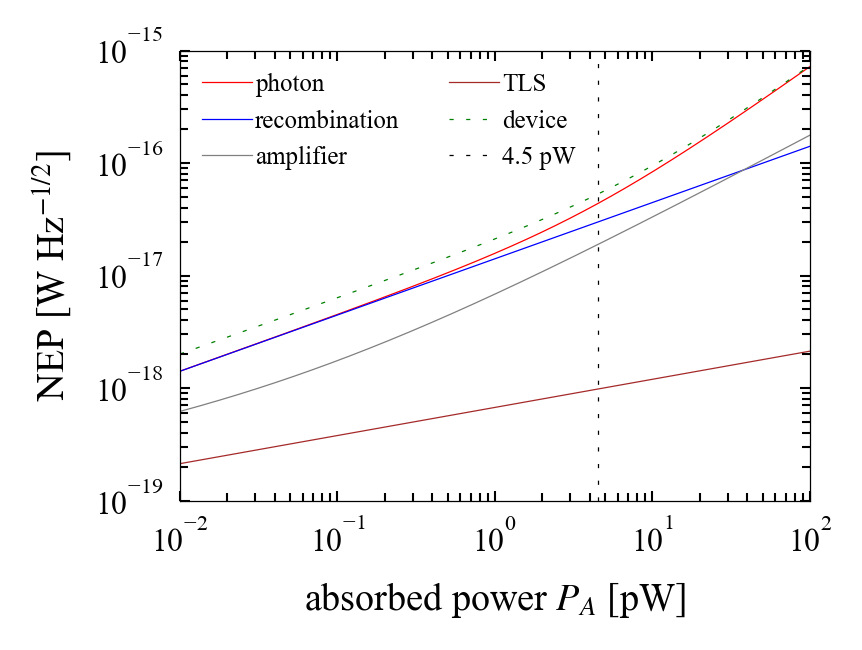

In [35]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('NEP [W Hz$^{-1/2}$]')

ax.plot(P_A_scale * P_A,
        photon**(1/2),
        color=photon_color, label='photon')

ax.plot(P_A_scale * P_A,
        recombination**(1/2),
        color=recombination_color, label='recombination')

ax.plot(P_A_scale * P_A,
        amplifier**(1/2),
        color=amp_color, label='amplifier')

ax.plot(P_A_scale * P_A,
        TLS**(1/2),
        color=TLS_color, label='TLS')

ax.plot(P_A_scale * P_A,
        device**(1/2),
        linestyle=':',
        color=device_color, label='device')

ax.axvline(P_A_scale * P_BICEP2, linestyle=':', color='black', label='4.5 pW')

ax.legend(loc='upper left', fontsize=6, ncol=2);

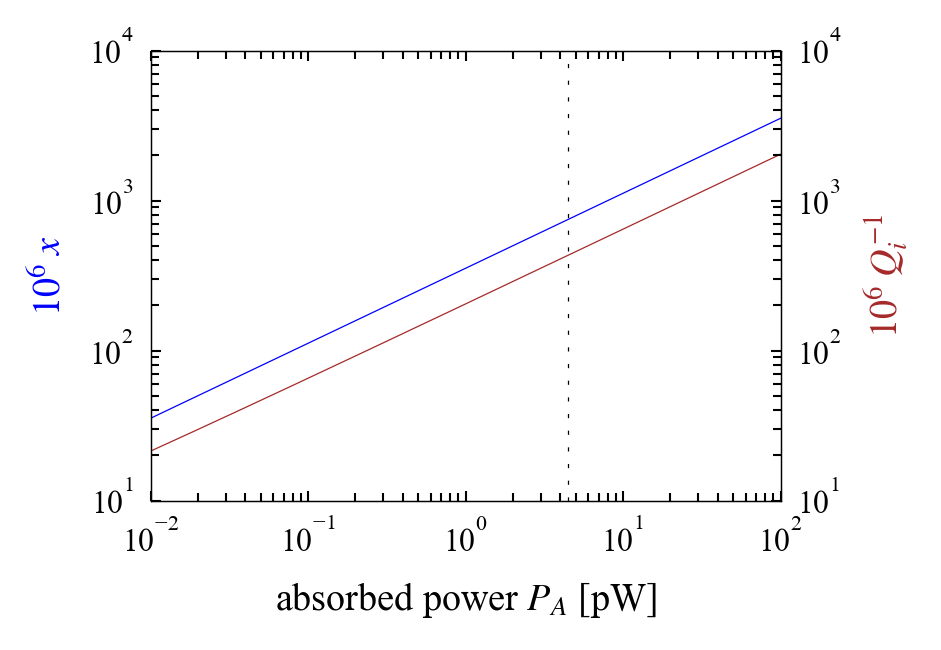

In [36]:
fig, x_ax = plt.subplots()
iQi_ax = x_ax.twinx()

x_ax.set_xscale('log')
x_ax.set_yscale('log')
iQi_ax.set_yscale('log')
x_ax.set_xlabel('absorbed power $P_A$ [pW]')
x_ax.set_ylabel('$10^6 \; x$', color=x_color)
iQi_ax.set_ylabel('$10^6 \; Q_i^{-1}$', color=iQi_color)

x_ax.axvline(P_A_scale * P_BICEP2, linestyle=':', color='black')

x_ax.plot(P_A_scale * P_A,
            1e6 * (kid.x(Gamma=Gamma) - kid.x(Gamma=kid.thermal_generation_rate())),
            color=x_color)

iQi_ax.plot(P_A_scale * P_A,
            1e6 * kid.iQi(Gamma=Gamma),
            color=iQi_color)

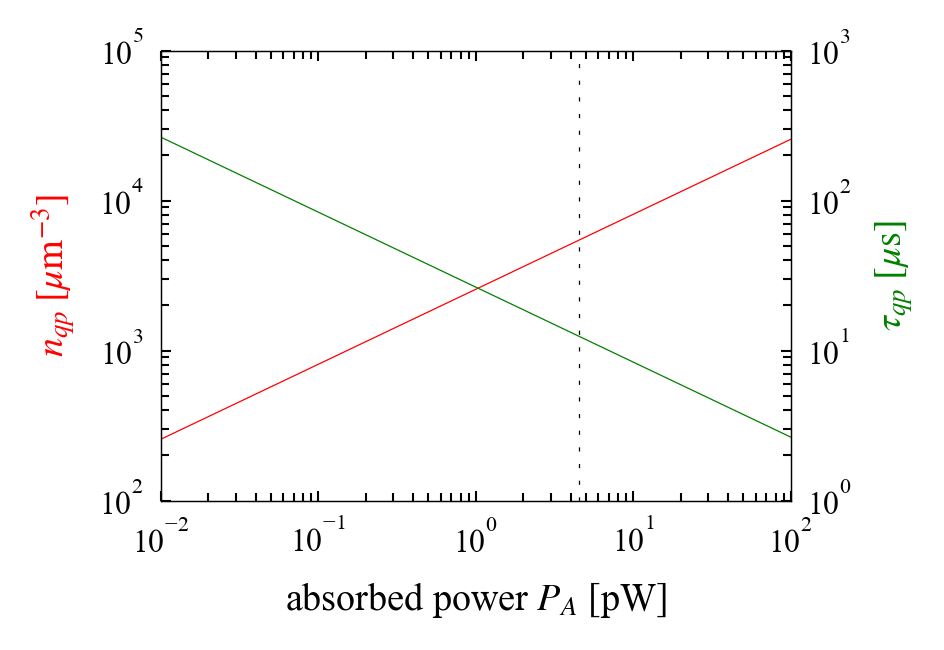

In [37]:
fig, n_ax = plt.subplots()
tau_ax = n_ax.twinx()

n_ax.set_xscale('log')
n_ax.set_yscale('log')
tau_ax.set_yscale('log')
n_ax.set_xlabel('absorbed power $P_A$ [pW]')
n_ax.set_ylabel(r'$n_{qp} \; [\mu \mathrm{m}^{-3}]$', color=n_color)
tau_ax.set_ylabel(r'$\tau_{qp} \; [\mu \mathrm{s}]$', color=tau_color)

n_ax.axvline(P_A_scale * P_BICEP2, linestyle=':', color='black')

n_ax.plot(P_A_scale * P_A,
          kid.N_qp(Gamma=Gamma) / nominal_volume_um3,
          color=n_color)

tau_ax.plot(P_A_scale * P_A,
            1e6 * kid.tau_qp(Gamma=Gamma),
            color=tau_color)

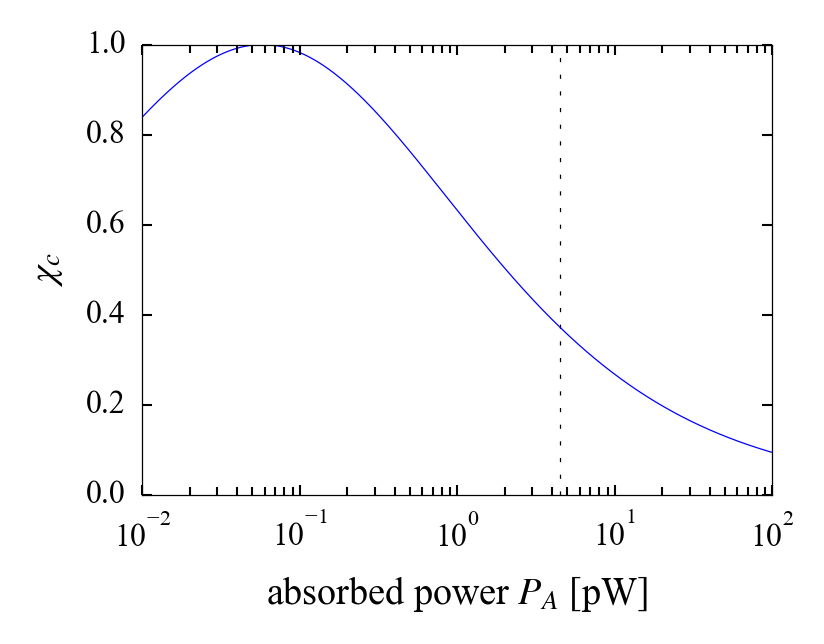

In [38]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel(r'$\chi_c$')
ax.axvline(P_A_scale * P_BICEP2, linestyle=':', color='black')
ax.semilogx(P_A_scale * P_A,
            kid.chi_c(kid.iQi(Gamma)))

In [44]:
V = np.linspace(nominal_volume_um3, 1000 * nominal_volume_um3, 1e3)

In [45]:
kid_V_R1 = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=V,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=1,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

kid_V_R5 = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=V,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=5,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

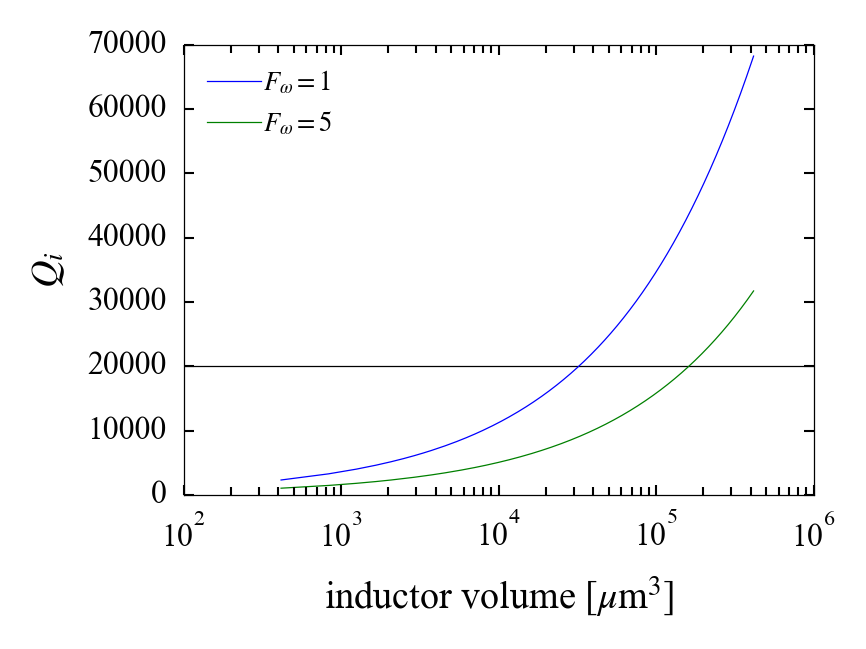

In [46]:
fig, ax = plt.subplots()
ax.axhline(20e3, color='black')
ax.plot(V, 1 / kid_V_R1.iQi(Gamma=Gamma_BICEP2), label='$F_\omega = 1$')
ax.plot(V, 1 / kid_V_R5.iQi(Gamma=Gamma_BICEP2), label='$F_\omega = 5$')
ax.set_xscale('log')
ax.set_xlabel('inductor volume [$\mu \mathrm{m}^3$]')
ax.set_ylabel('$Q_i$')
ax.legend(loc='best', fontsize='xx-small');